# Comparison of online CCA algorithms

### Imports

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import time

from cca_algorithms import bio_cca, gen_oja, msg_cca, asy_cca, bio_rrr
from util import correlation_matrix, error, msg_error, biorrr_error, constraint_error, add_fill_lines

### Load synthetic dataset

In [2]:
# select the desired dataset and number of epochs

# dataset = 'synthetic'; epochs = 1
dataset = 'mediamill'; epochs = 3

# load dataset

X = np.load(f'datasets/{dataset}/view1.npy')
Y = np.load(f'datasets/{dataset}/view2.npy')

# dataset dimensions

x_dim = X.shape[0]
y_dim = Y.shape[0]
samples = X.shape[1]

### Offline solution

In [3]:
# Covariance matrices

Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples

# Inverse matrices

sig_y, Uy = np.linalg.eig(Cyy)

Cyy_inv = Uy@np.diag(1./sig_y)@Uy.T

# Correlation matrix

Rxy = correlation_matrix(Cxx, Cyy, Cxy)

# SVD

u, canonical_correlations, vh = np.linalg.svd(Rxy)

### Online algorithms

In [4]:
# Parameters

trials = 1; z_dim = 1; iters = epochs*samples; training_samples = 1000

In [5]:
# Maximum of the objective

max_obj = sum(canonical_correlations[:z_dim])/2

In [6]:
# Specify which algorithms to run

algorithms = []

# algorithms.append('Bio-CCA')
# algorithms.append('MSG-CCA')
# algorithms.append('Asymmetric-CCA')
algorithms.append('Bio-RRR')
# if z_dim==1: algorithms.append('Gen-Oja')

In [7]:
alg_error = {}

for alg in algorithms:
    alg_error[alg] = np.zeros((trials,iters))
    
if 'Bio-CCA' in algorithms:
    biocca_constraint_error = np.zeros((trials,iters))

In [8]:
for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
                
    # Initialize Bio-CCA
    
    if 'Bio-CCA' in algorithms:
        biocca = bio_cca(z_dim,x_dim,y_dim,dataset)    
        biocca_Vx = np.zeros((iters,x_dim,z_dim))
        biocca_Vy = np.zeros((iters,y_dim,z_dim))
    
    # Initialize MSG-CCA
    
    if 'MSG-CCA' in algorithms:
        msgcca = msg_cca(z_dim,x_dim,y_dim)
        msgcca_M = np.zeros((iters,x_dim,y_dim))
    
    # Initialize Asymmetric-CCA
    
    if 'Asymmetric-CCA' in algorithms:
        asycca = asy_cca(z_dim,x_dim,y_dim,dataset)
        asycca_Vx = np.zeros((iters,x_dim,z_dim))
        asycca_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Bio-RRR
    
    if 'Bio-RRR' in algorithms:
        biorrr = bio_rrr(z_dim,x_dim,y_dim,dataset)
        biorrr_Vx = np.zeros((iters,x_dim,z_dim))
        biorrr_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Gen-Oja
    
    if 'Gen-Oja' in algorithms:
        genoja = gen_oja(x_dim,y_dim,dataset)
        genoja_vx = np.zeros((iters,x_dim,1))
        genoja_vy = np.zeros((iters,y_dim,1))
            
    # Run online algorithms
    
    print('Running online algorithms...')
    
    for i_epoch in range(epochs):
        
        print(f'Epoch {i_epoch+1} out of {epochs}:')
        
        # Random permutation of the inputs

        idx = np.random.permutation(samples)
    
        # MSG-CCA covariance estimation on training samples
        
        if i_epoch==0 and 'msgcca' in algorithms:
            msgcca.cov_estimation(X[:,idx[:]],Y[:,idx[:]])
            
        # Online updates

        for i_sample in range(samples):
            
            i_iter = i_epoch*samples + i_sample

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            # online updates

            if 'Bio-CCA' in algorithms: biocca_Vx[i_iter], biocca_Vy[i_iter] = biocca.fit_next(x,y)
            if 'MSG-CCA' in algorithms: msgcca_M[i_iter] = msgcca.fit_next(x,y)
            if 'Asymmetric-CCA' in algorithms: asycca_Vx[i_iter], asycca_Vy[i_iter] = asycca.fit_next(x,y)            
            if 'Bio-RRR' in algorithms: biorrr_Vx[i_iter], biorrr_Vy[i_iter] = biorrr.fit_next(x,y)
            if 'Gen-Oja' in algorithms: genoja_vx[i_iter], genoja_vy[i_iter] = genoja.fit_next(x,y)
        
    # Compute error
                
    print('Computing errors...')

    for i_iter in range(iters):
        if 'Bio-CCA' in algorithms: 
            alg_error['Bio-CCA'][i_trial,i_iter] = error(biocca_Vx[i_iter], biocca_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)
            biocca_constraint_error[i_trial,i_iter] = constraint_error(biocca_Vx[i_iter], biocca_Vy[i_iter], Cxx, Cyy)
        if 'MSG-CCA' in algorithms: alg_error['MSG-CCA'][i_trial,i_iter] = msg_error(msgcca_M[i_iter], Rxy, max_obj)
        if 'Asymmetric-CCA' in algorithms: alg_error['Asymmetric-CCA'][i_trial,i_iter] = error(asycca_Vx[i_iter], asycca_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)
        if 'Bio-RRR' in algorithms: alg_error['Bio-RRR'][i_trial,i_iter] = biorrr_error(biorrr_Vx[i_iter], biorrr_Vy[i_iter], Cxx, Cyy_inv, Cxy, max_obj)
        if 'Gen-Oja' in algorithms: alg_error['Gen-Oja'][i_trial,i_iter] = error(genoja_vx[i_iter], genoja_vy[i_iter], Cxx, Cyy, Cxy, max_obj)

# save data 
            
pkl.dump(alg_error, open(f'error/{dataset}_{z_dim}-dim.p', 'wb'))

Trial 1 out of 1:
Running online algorithms...
Epoch 1 out of 10:
Epoch 2 out of 10:
Epoch 3 out of 10:
Epoch 4 out of 10:
Epoch 5 out of 10:
Epoch 6 out of 10:
Epoch 7 out of 10:
Epoch 8 out of 10:
Epoch 9 out of 10:
Epoch 10 out of 10:
Computing errors...


### Comparison plots

In [9]:
font = {'weight' : 'normal', 'size' : 15}

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

plt.rc('font', **font)

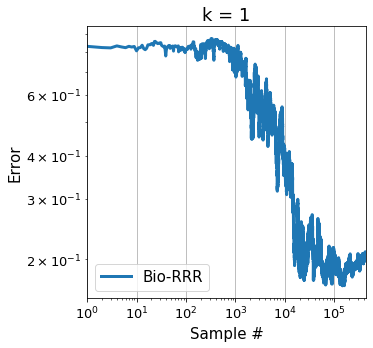

In [10]:
alg_error = pkl.load(open(f'error/{dataset}_{z_dim}-dim.p', 'rb'))

linewidth = 3

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    add_fill_lines(ax, t, alg_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1,iters))
plt.xlabel('Sample #')
plt.ylabel('Error')

plt.savefig(f'plots/{dataset}_{z_dim}-dim.png', dpi=300, transparent='true', bbox_inches='tight')